# Example usage of gw_eccentricity

Package to measure eccentricity and mean anomaly from a gravitational waveform.    
For package details, see https://pypi.org/project/gw_eccentricity   
Paper: FIXME ARIF

In [2]:
import sys
import subprocess
# Get the path to the base directory of the repo
git_home = subprocess.check_output(['git', 'rev-parse', '--show-toplevel'], text=True).strip('\n')
sys.path.append(git_home)
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import h5py

from gw_eccentricity import measure_eccentricity
from gw_eccentricity import get_available_methods
from gw_eccentricity.plot_settings import use_fancy_plotsettings, labelsDict

use_fancy_plotsettings()

## Read the documentation

In [4]:
help(measure_eccentricity)

Help on function measure_eccentricity in module gw_eccentricity.gw_eccentricity:

measure_eccentricity(tref_in=None, fref_in=None, method='Amplitude', dataDict=None, num_orbits_to_exclude_before_merger=2, extra_kwargs=None)
    Measure eccentricity and mean anomaly from a gravitational waveform.
    
    Eccentricity is measured using the GW frequency omega22(t) = dphi22(t)/dt,
    where phi22(t) is the phase of the (2, 2) waveform mode. We currently only
    allow time-domain, nonprecessing waveforms. We evaluate omega22(t) at
    pericenter times, t_pericenters, and build a spline interpolant
    omega22_pericenters(t) using those points. Similarly, we build
    omega22_apocenters(t) using omega22(t) at the apocenter times,
    t_apocenters. Finally, eccentricity is defined using omega22_pericenters(t)
    and omega22_apocenters(t), as described in Eq.(1) of arxiv:xxxx.xxxx. Mean
    anomaly is defined using t_pericenters, as described in Eq.(2) of
    arxiv:xxxx.xxxx.
    
    FIXME

## Load example data

As an example, we use an eccentric, equal-mass nonspinning binary black hole waveform from the SXS catalog and the corresponding zero eccentricity waveform using the NRHybSur3dq8 model.

In [5]:
# Load the eccentric NR waveform and the corresponding zero-ecc surrogate waveform
f = h5py.File(f"{git_home}/data/SXS_BBH_2305_22.h5", "r")
t_ecc_NR, h22_ecc_NR = f["t"][:], f["h22"][:]
t_zeroecc_sur, h22_zeroecc_sur = f["t_zeroecc"][:], f["h22_zeroecc"][:]

# Setup dataDict (Note the required format)
dataDict = {"t": t_ecc_NR,
           "hlm": {(2, 2): h22_ecc_NR},
           "t_zeroecc": t_zeroecc_sur,
           "hlm_zeroecc": {(2, 2): h22_zeroecc_sur}}
f.close()

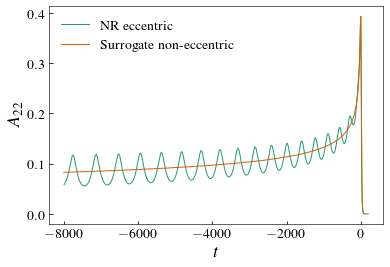

In [6]:
# Plot the two waveforms
plt.plot(dataDict["t"], np.abs(dataDict["hlm"][(2, 2)]), label="NR eccentric")
plt.plot(dataDict["t_zeroecc"], np.abs(dataDict["hlm_zeroecc"][(2, 2)]), label="Surrogate non-eccentric")
plt.legend()
plt.xlabel(r"$t$")
plt.ylabel(r"$A_{22}$");

## Usage

### Get the available methods

We implement different methods to measure eccentricity and mean anomaly.   
Recommended methods are 'AmplitudeFits' or 'ResidualAmplitude'.   
See the documentation above for what different methods do.  

In [7]:
get_available_methods()

['Amplitude',
 'Frequency',
 'ResidualAmplitude',
 'ResidualFrequency',
 'AmplitudeFits',
 'FrequencyFits']

### Measure eccentricity/mean_ano at a single time

In [8]:
tref_in = -5500
for method in get_available_methods():
    gwecc_dict = measure_eccentricity(tref_in=tref_in,
                                      method=method,
                                      dataDict=dataDict,
                                      extra_kwargs={"debug": False})
    tref_out = gwecc_dict["tref_out"]
    ecc_ref = gwecc_dict["eccentricity"]
    meanAno_ref = gwecc_dict["mean_anomaly"]
    print(f"method={method:20s} ecc={ecc_ref:.6f}, meanAno = {meanAno_ref:.6f}")

method=Amplitude            ecc=0.234925, meanAno = 4.915010
method=Frequency            ecc=0.234893, meanAno = 4.915923
method=ResidualAmplitude    ecc=0.234959, meanAno = 4.919442
method=ResidualFrequency    ecc=0.234962, meanAno = 4.921472
method=AmplitudeFits        ecc=0.234962, meanAno = 4.918334
method=FrequencyFits        ecc=0.234962, meanAno = 4.921232


`measure_eccentricity` function returns a dictionary containing the measured values of eccentricity, mean anomaly and the reference time/frequency where these are measured. It also returns the `gwecc_object` that contains all the relevant variables that are internally used.

In [9]:
gwecc_dict

{'eccentricity': 0.23496209210576158,
 'mean_anomaly': 4.92123180257207,
 'tref_out': -5500,
 'gwecc_object': <gw_eccentricity.eccDefinitionUsingFrequencyFits.eccDefinitionUsingFrequencyFits at 0x7f3014ceb4c0>}

### Measure eccentricity/mean_ano at a single frequency

In [10]:
fref_in = 0.005
for method in get_available_methods():
    gwecc_dict = measure_eccentricity(fref_in=fref_in,
                                      method=method,
                                      dataDict=dataDict,
                                      extra_kwargs={"debug": False})
    fref_out = gwecc_dict["fref_out"]
    ecc_ref = gwecc_dict["eccentricity"]
    meanAno_ref = gwecc_dict["mean_anomaly"]
    print(f"method={method:20s} ecc={ecc_ref:.6f}, meanAno = {meanAno_ref:.6f}")

method=Amplitude            ecc=0.209670, meanAno = 3.806604
method=Frequency            ecc=0.209658, meanAno = 3.800770
method=ResidualAmplitude    ecc=0.209706, meanAno = 3.824476
method=ResidualFrequency    ecc=0.209723, meanAno = 3.823542
method=AmplitudeFits        ecc=0.209706, meanAno = 3.821522
method=FrequencyFits        ecc=0.209740, meanAno = 3.811678


**NOTE:** In the similar way, one can measure the eccentricity and mean anomaly at an array of times/frequencies also.

### Get Average frequency $\langle\omega_{22}\rangle$

$\langle t\rangle$ and $\langle\omega_{22}\rangle$ can be computed using `get_omega22_average`

In [11]:
# Let's use one particular method for this example
method = "ResidualAmplitude"
fref_in = 0.005
gwecc_dict = measure_eccentricity(fref_in=fref_in,
                                  method=method,
                                  dataDict=dataDict,
                                  extra_kwargs={"debug": False})
gwecc_object = gwecc_dict["gwecc_object"]

In [12]:
t_for_omega22_average, omega22_average = gwecc_object.get_omega22_average()
t_for_omega22_average, omega22_average

(array([-7448.91291599, -7448.81291599, -7448.71291599, ...,
         -434.61291599,  -434.51291599,  -434.41291599]),
 array([0.02437398, 0.02437416, 0.02437434, ..., 0.07071255, 0.07071818,
        0.07072382]))

In [13]:
gwecc_object.get_fref_bounds()

(0.00387923921634941, 0.011256044948576703)

## Making diagnostic plots

The library comes with useful methods to make diagnostic plots when the resulting eccentricty does not look good. Each of the plots could be used to investigate different issues that might be causing the unwanted features in the measured eccentricity.

For demonstration purpose, let's try measuring the eccentricity at a single time using only `ResidualAmplitude` method

In [18]:
tref_in = -5000

The diagnostic plots are available through the eccentricity measurement module object contained in the returned dict.

In [19]:
method = "ResidualAmplitude"
gwecc_dict = measure_eccentricity(tref_in=tref_in,
                                  method=method,
                                  dataDict=dataDict,
                                  extra_kwargs={"debug": False})

In [20]:
gwecc_object = gwecc_dict["gwecc_object"]

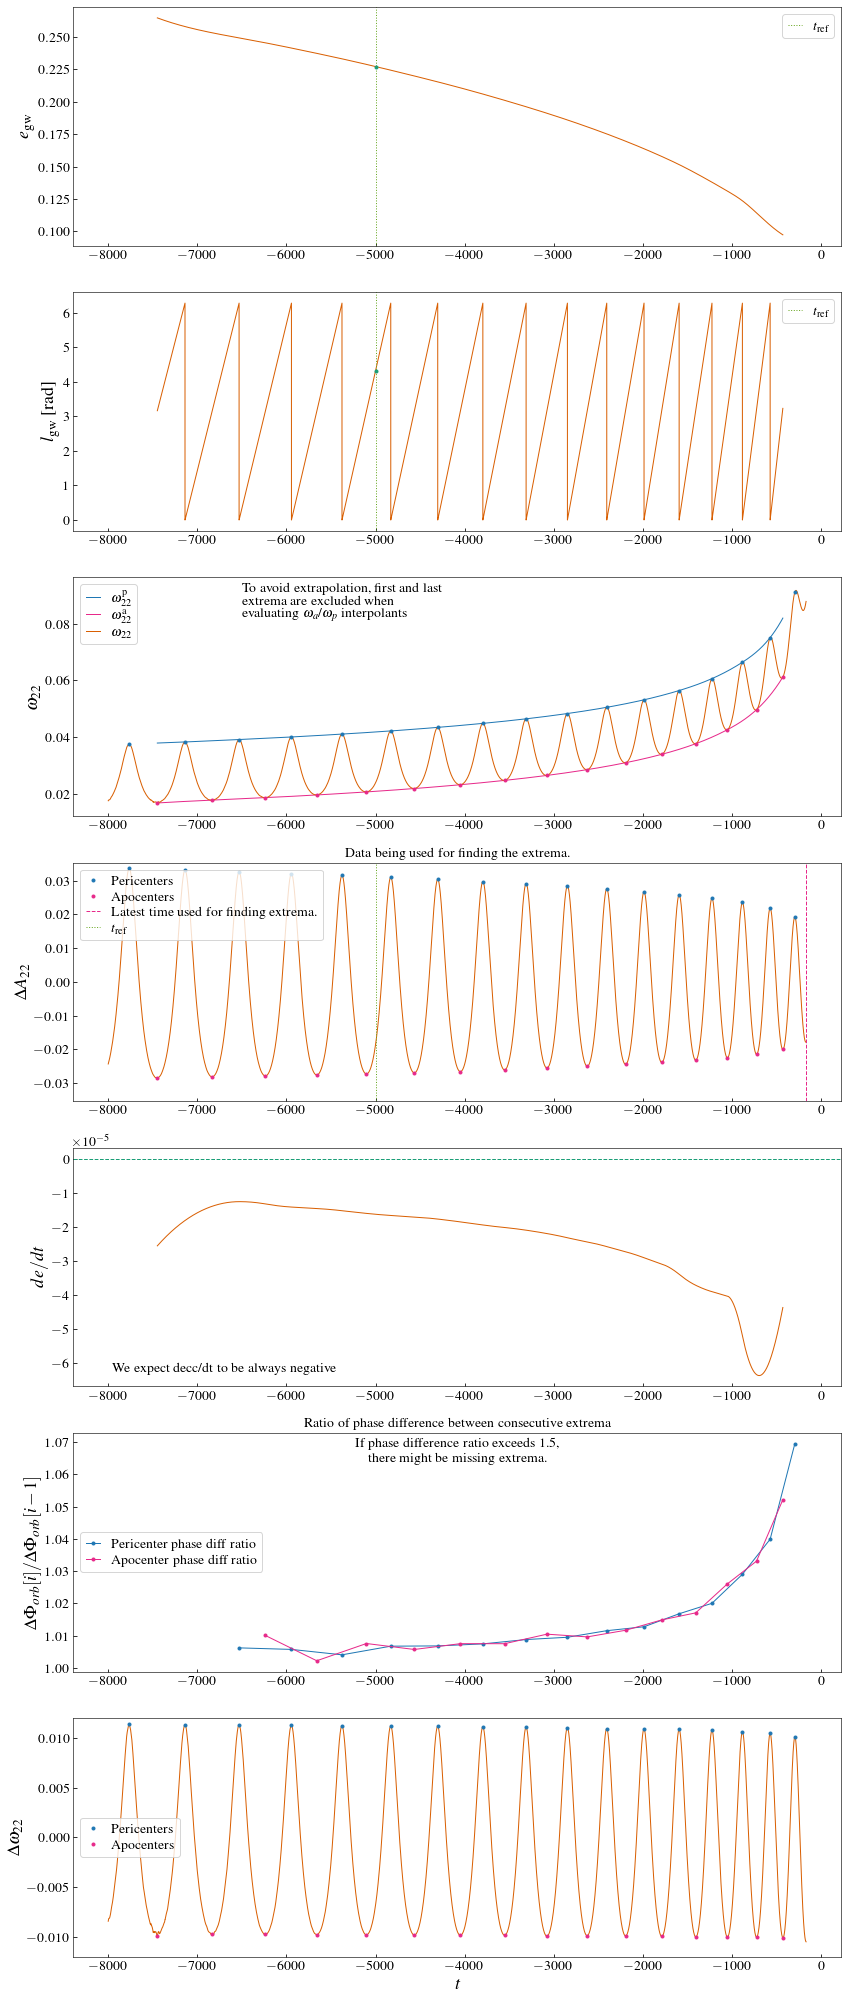

In [21]:
fig, ax = gwecc_object.make_diagnostic_plots()

**NOTE:** The vertical dotted line indicating the reference time is shown only when the input time is a scalar, i.e., int/float and not an array.

Let's look at each of these plots separately.

**Eccentricity vs Time:**

This plot shows the evolution of eccentricity as a function of time.

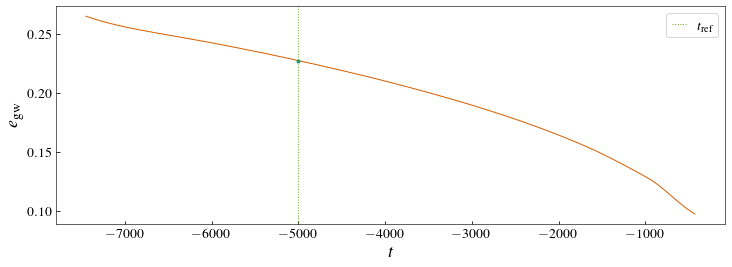

In [22]:
fig, ax = gwecc_object.plot_measured_ecc()

**Mean anomaly vs Time:**

This plot shows the evolution of mean anomaly as a function of time

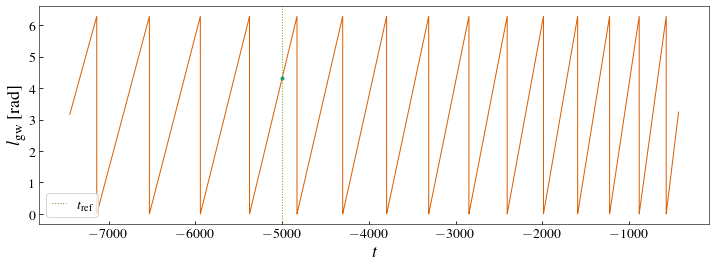

In [23]:
fig, ax = gwecc_object.plot_mean_ano()

**$\omega_{22}$ with the locations of apocenter and pericenter**

This plot shows the $\omega_{22}(t)$ with the locations of the apocenters and pericenters that are being used for measuring eccentricity indicated by circles.<br>
This would show if the method is missing any peaks/troughs or selecting one which is not a peak/trough.

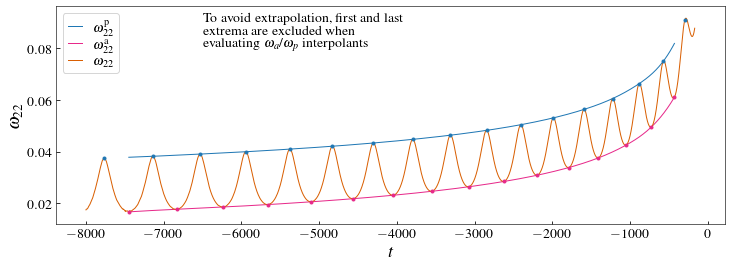

In [24]:
fig, ax = gwecc_object.plot_omega22()

**Data being used to find extrema**

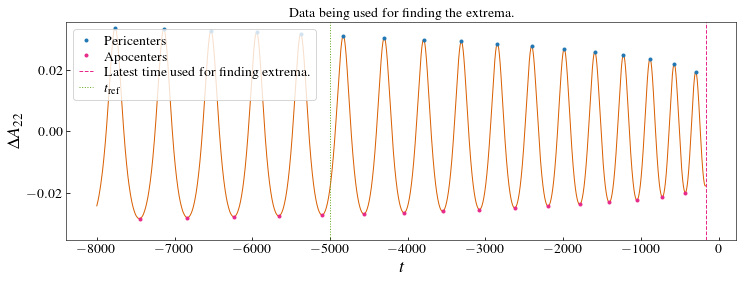

In [25]:
fig, ax = gwecc_object.plot_data_used_for_finding_extrema()

**$de/dt$ vs Time:**

This plot shows the first derivative of eccentricity as a function of time. The eccentricity should be a monotonically decreasing function of time. Therefore, wherever $de/dt$ becomes positive implies non-monotonic eccentricity due unphysical features.

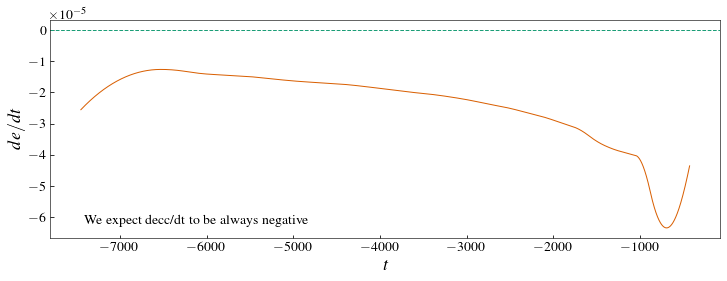

In [26]:
fig, ax = gwecc_object.plot_decc_dt()

**Ratio of $\Delta \phi_{\mathrm{orb}}$ between consecutive peaks/troughs vs Time:**

$\Delta \phi_{\mathrm{orb}}^{i}/\Delta \phi_{\mathrm{orb}}^{i-1}$, where $\Delta \phi_{\mathrm{orb}}^{i}$
is the change in orbital phase from the previous extrema to the ith extrema. This helps look for missing extrema, as there will be a drastic (roughly factor of 2) change in
$\Delta \phi_{\mathrm{orb}}^{i}$ if there is a missing extrema, and the ratio will go from ~1 to ~2.

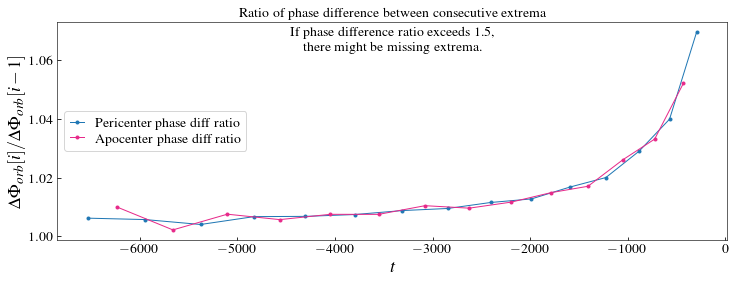

In [27]:
fig, ax = gwecc_object.plot_phase_diff_ratio_between_pericenters()

**$\Delta A_{22}$ vs Time:**

$\Delta A_{22}$ is the residual amplitude of the 22 mode, defined as $\Delta A_{22} = A_{22}(e) - A_{22}(e=0)$, where we substract the 22 mode amplitude of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode amplitude of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

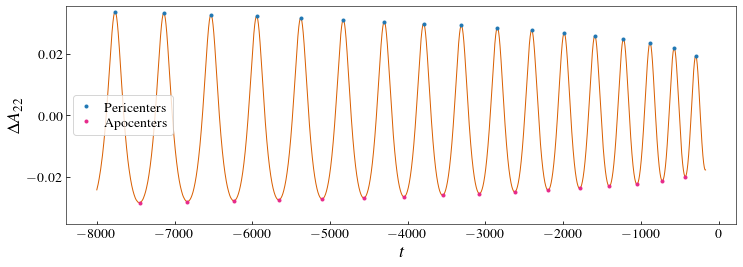

In [28]:
fig, ax = gwecc_object.plot_residual_amp22()

**$\Delta \omega_{22}$ vs Time:**

$\Delta \omega_{22}$ is the residual omega of the 22 mode, defined as $\Delta \omega_{22} = \omega_{22}(e) - \omega_{22}(e=0)$, where we substract the 22 mode omega of the qausi-circular waveform (generated using the same set of parameters as the eccentric one, except we set the eccentricity to be zero) from the 22 mode omega of the eccentric waveform.
**NOTE:** This is available only if the provided data dictionary contains zeroecc data.

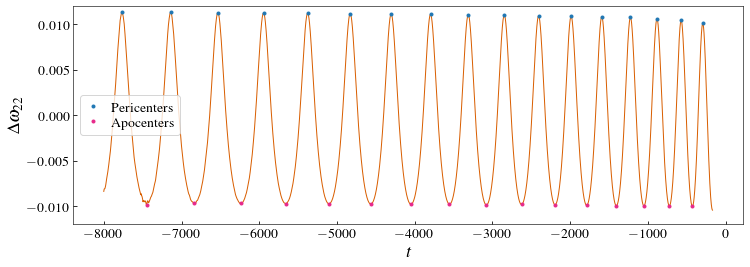

In [29]:
fig, ax = gwecc_object.plot_residual_omega22()

## Checking $\langle \omega_{22}\rangle$
**$\langle\omega_{22}\rangle$ vs $\langle t\rangle$**:
A plot of the average frequency as function of time can be generated irrespective of whether eccentricity is measured at a reference frequency or time using the following method

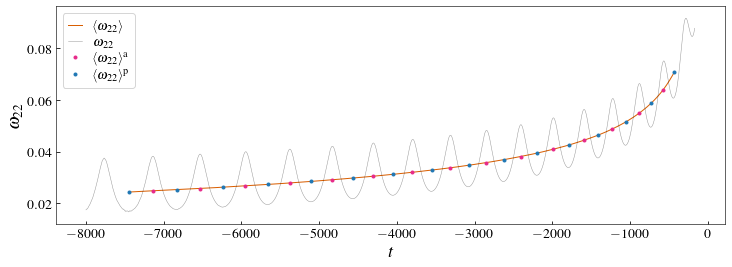

In [30]:
fig, ax = gwecc_object.plot_omega22_average()